# Generating Synthetic MMM Data

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pymc import do
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generating Covariates Data

In [3]:
# Configuration Parameters

n_dates = 200

date_range = pd.date_range(start="2020-01-01", freq="W-MON", periods=n_dates)

t = np.arange(n_dates) / n_dates

n_channels = 4

l_max = 8

n_fourier_modes = 4

chol_eta = 2

coords = {"channel": [f"x{i}" for i in range(n_channels)], "date": date_range}

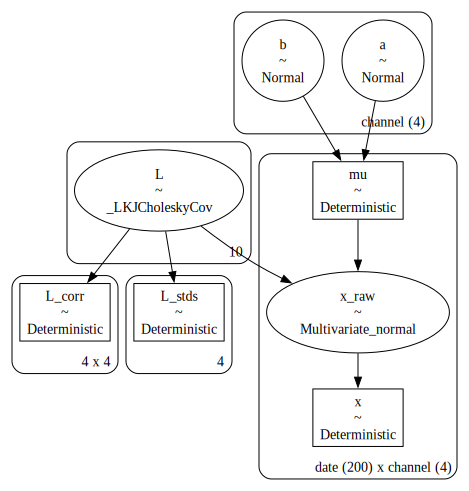

In [4]:
with pm.Model(coords=coords) as covariates_model:
    L, _, _ = pm.LKJCholeskyCov(
        "L", n=len(coords["channel"]), eta=chol_eta, sd_dist=pm.Exponential.dist(lam=2)
    )

    a = pm.Normal("a", mu=0, sigma=1, dims="channel")

    b = pm.Normal("b", mu=0, sigma=1, dims="channel")

    mu = pm.Deterministic("mu", a + b * t[..., None], dims=("date", "channel"))

    x_raw = pm.MvNormal("x_raw", mu=mu, chol=L, dims=("date", "channel"))

    x = pm.Deterministic("x", pt.softplus(x_raw), dims=("date", "channel"))

pm.model_to_graphviz(covariates_model)

In [5]:
x_data = pm.draw(covariates_model.x, draws=1, random_seed=rng)

mmm_df = pd.DataFrame(x_data, columns=coords["channel"]).assign(
    date=date_range, y_dummy=np.ones(n_dates)
)

col = mmm_df.pop("date")
mmm_df.insert(0, "date", col)

mmm_df.head()

,date,x0,x1,x2,x3,y_dummy
0,2020-01-06,1.994378,0.356911,0.344963,0.626192,1.0
1,2020-01-13,1.780495,0.312379,0.298067,0.511850,1.0
2,2020-01-20,1.327815,0.360876,0.420177,0.168309,1.0
3,2020-01-27,1.175901,0.438417,0.352416,0.244191,1.0
4,2020-02-03,1.547700,0.438525,0.331047,0.132453,1.0


## Specify Model Configuration

In [6]:
intercept_true = pm.draw(pm.Normal.dist(), draws=1, random_seed=rng)
adstock_alpha_true = pm.draw(
    pm.Beta.dist(alpha=1, beta=3), draws=len(coords["channel"]), random_seed=rng
)
saturation_beta_true = pm.draw(
    pm.HalfNormal.dist(sigma=3), draws=len(coords["channel"]), random_seed=rng
)
saturation_lam_true = pm.draw(
    pm.Gamma.dist(alpha=2, beta=1), draws=len(coords["channel"]), random_seed=rng
)

gamma_fourier_true = pm.draw(pm.Laplace.dist(mu=0, b=0.1), random_seed=rng)

sigma_likelihood_true = pm.draw(pm.HalfNormal.dist(sigma=3), draws=1, random_seed=rng)


model_config = {
    "intercept": Prior("Normal", mu=0, sigma=2),
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=1, dims="channel"),
    "gamma_control": Prior("Normal", mu=0, sigma=1, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.1, dims="fourier_mode"),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=3)),
}

mmm_generator = MMM(
    date_column="date",
    target_column="y_dummy",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=l_max),
    saturation=LogisticSaturation(),
    yearly_seasonality=n_fourier_modes,
    model_config=model_config,
)

## Generate Target Variable

In [7]:
X = mmm_df.drop(columns=["y_dummy"])
y_dummy = mmm_df["y_dummy"]

mmm_generator.build_model(X, y_dummy)
mmm_generator.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)

In [8]:
mmm_generator.model = do(
    mmm_generator.model,
    {
        "intercept_contribution": intercept_true,
        "adstock_alpha": adstock_alpha_true,
        "saturation_beta": saturation_beta_true,
        "saturation_lam": saturation_lam_true,
        "gamma_fourier": gamma_fourier_true * np.ones(2 * n_fourier_modes),
        "y_sigma": sigma_likelihood_true,
    },
)

In [9]:
with mmm_generator.model:
    idata_obs = pm.sample_prior_predictive(
        draws=1,
        var_names=[
            "y",
            "y_original_scale",
            "channel_contribution_original_scale",
        ],
        random_seed=rng,
    )

Sampling: [y]


In [10]:
y_obs = idata_obs["prior"]["y_original_scale"].sel(chain=0, draw=0)

mmm_df["y_obs"] = y_obs

# Remove last dates (adstock lag)
mmm_df = mmm_df.tail(-l_max)
coords["date"] = coords["date"][l_max:]

mmm_df.head()

,date,x0,x1,x2,x3,y_dummy,y_obs
8,2020-03-02,2.326932,0.200608,0.356830,0.255256,1.0,3.520741
9,2020-03-09,1.905357,0.280784,0.439101,0.314913,1.0,3.788621
10,2020-03-16,2.138024,0.294969,0.343899,0.163479,1.0,4.260390
11,2020-03-23,0.490725,0.249222,0.355371,0.448806,1.0,2.956959
12,2020-03-30,0.670504,0.382408,0.390481,0.292559,1.0,3.098025


In [11]:
mmm_df[coords["channel"]].corr()

,x0,x1,x2,x3
x0,1.000000,-0.219666,0.037299,-0.359930
x1,-0.219666,1.000000,-0.052441,-0.185507
x2,0.037299,-0.052441,1.000000,-0.079634
x3,-0.359930,-0.185507,-0.079634,1.000000


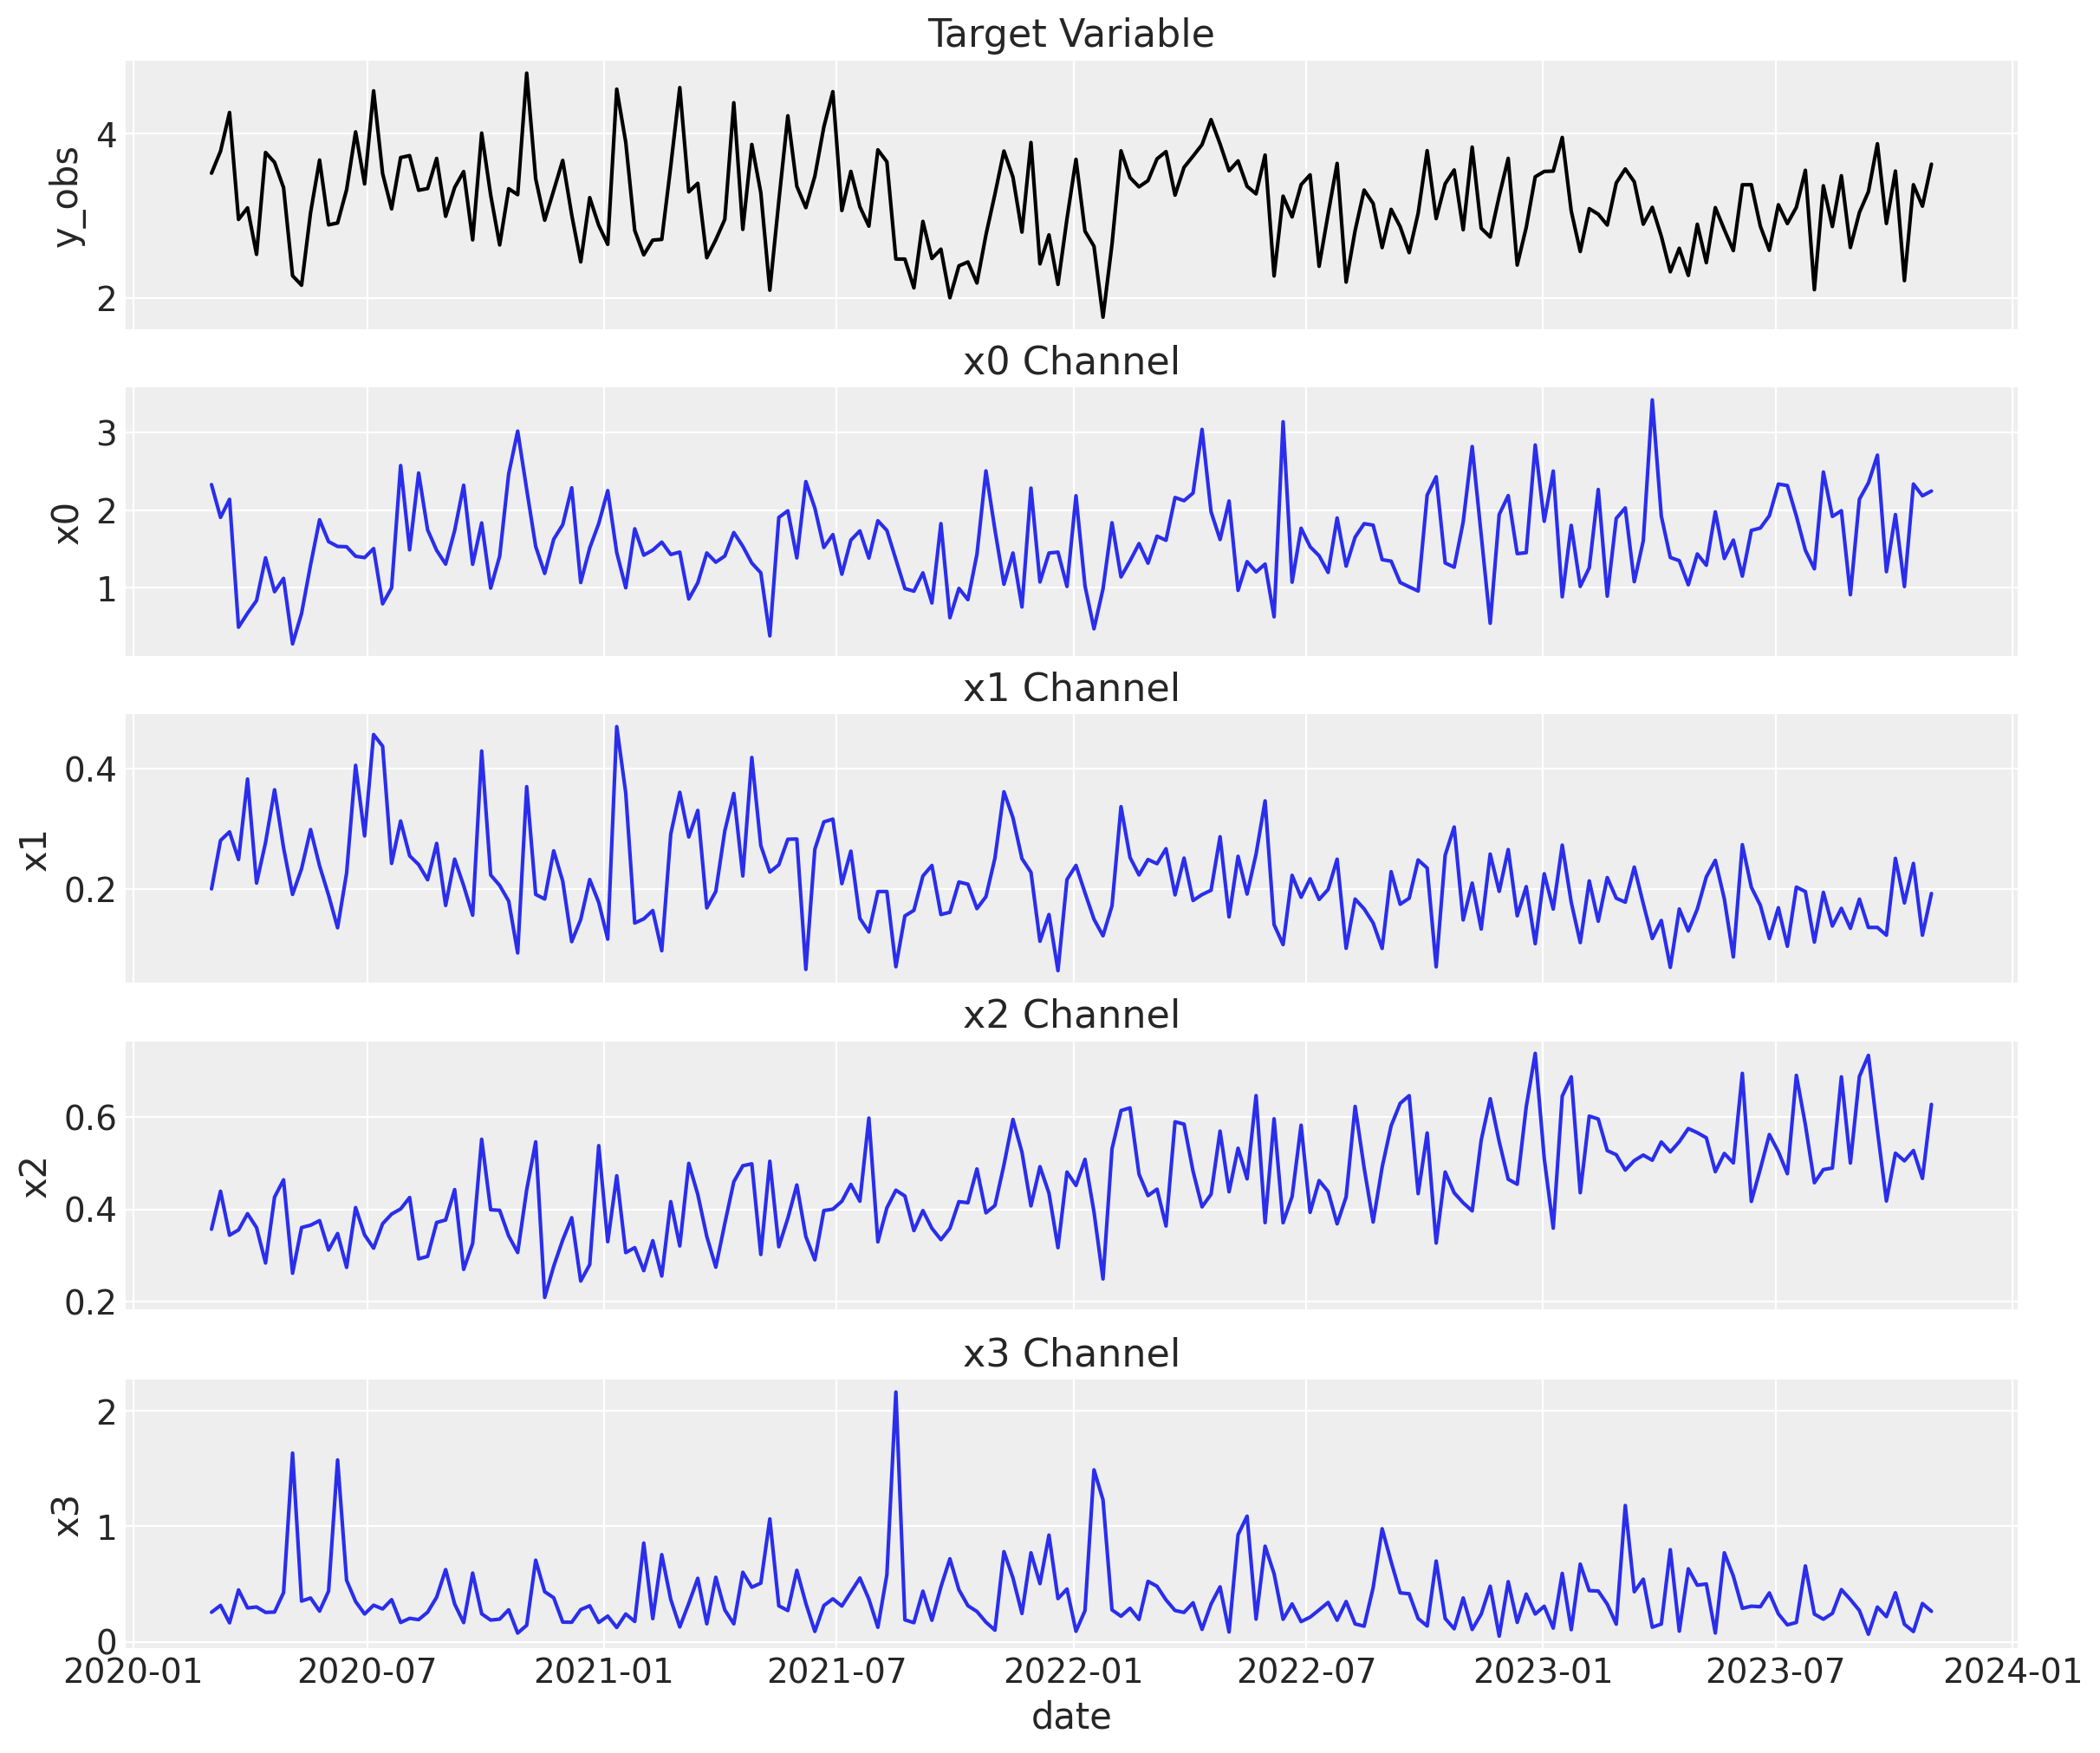

In [12]:
fig, ax = plt.subplots(
    nrows=len(coords["channel"]) + 1,
    figsize=(12, len(coords["channel"]) * 2.5),
    sharex=True,
)

sns.lineplot(x="date", y="y_obs", data=mmm_df, color="black", ax=ax[0])
ax[0].set_title("Target Variable")

for i, channel in enumerate(coords["channel"]):
    sns.lineplot(x="date", y=channel, data=mmm_df, color="C0", ax=ax[i + 1])
    ax[i + 1].set_title(f"{channel} Channel")

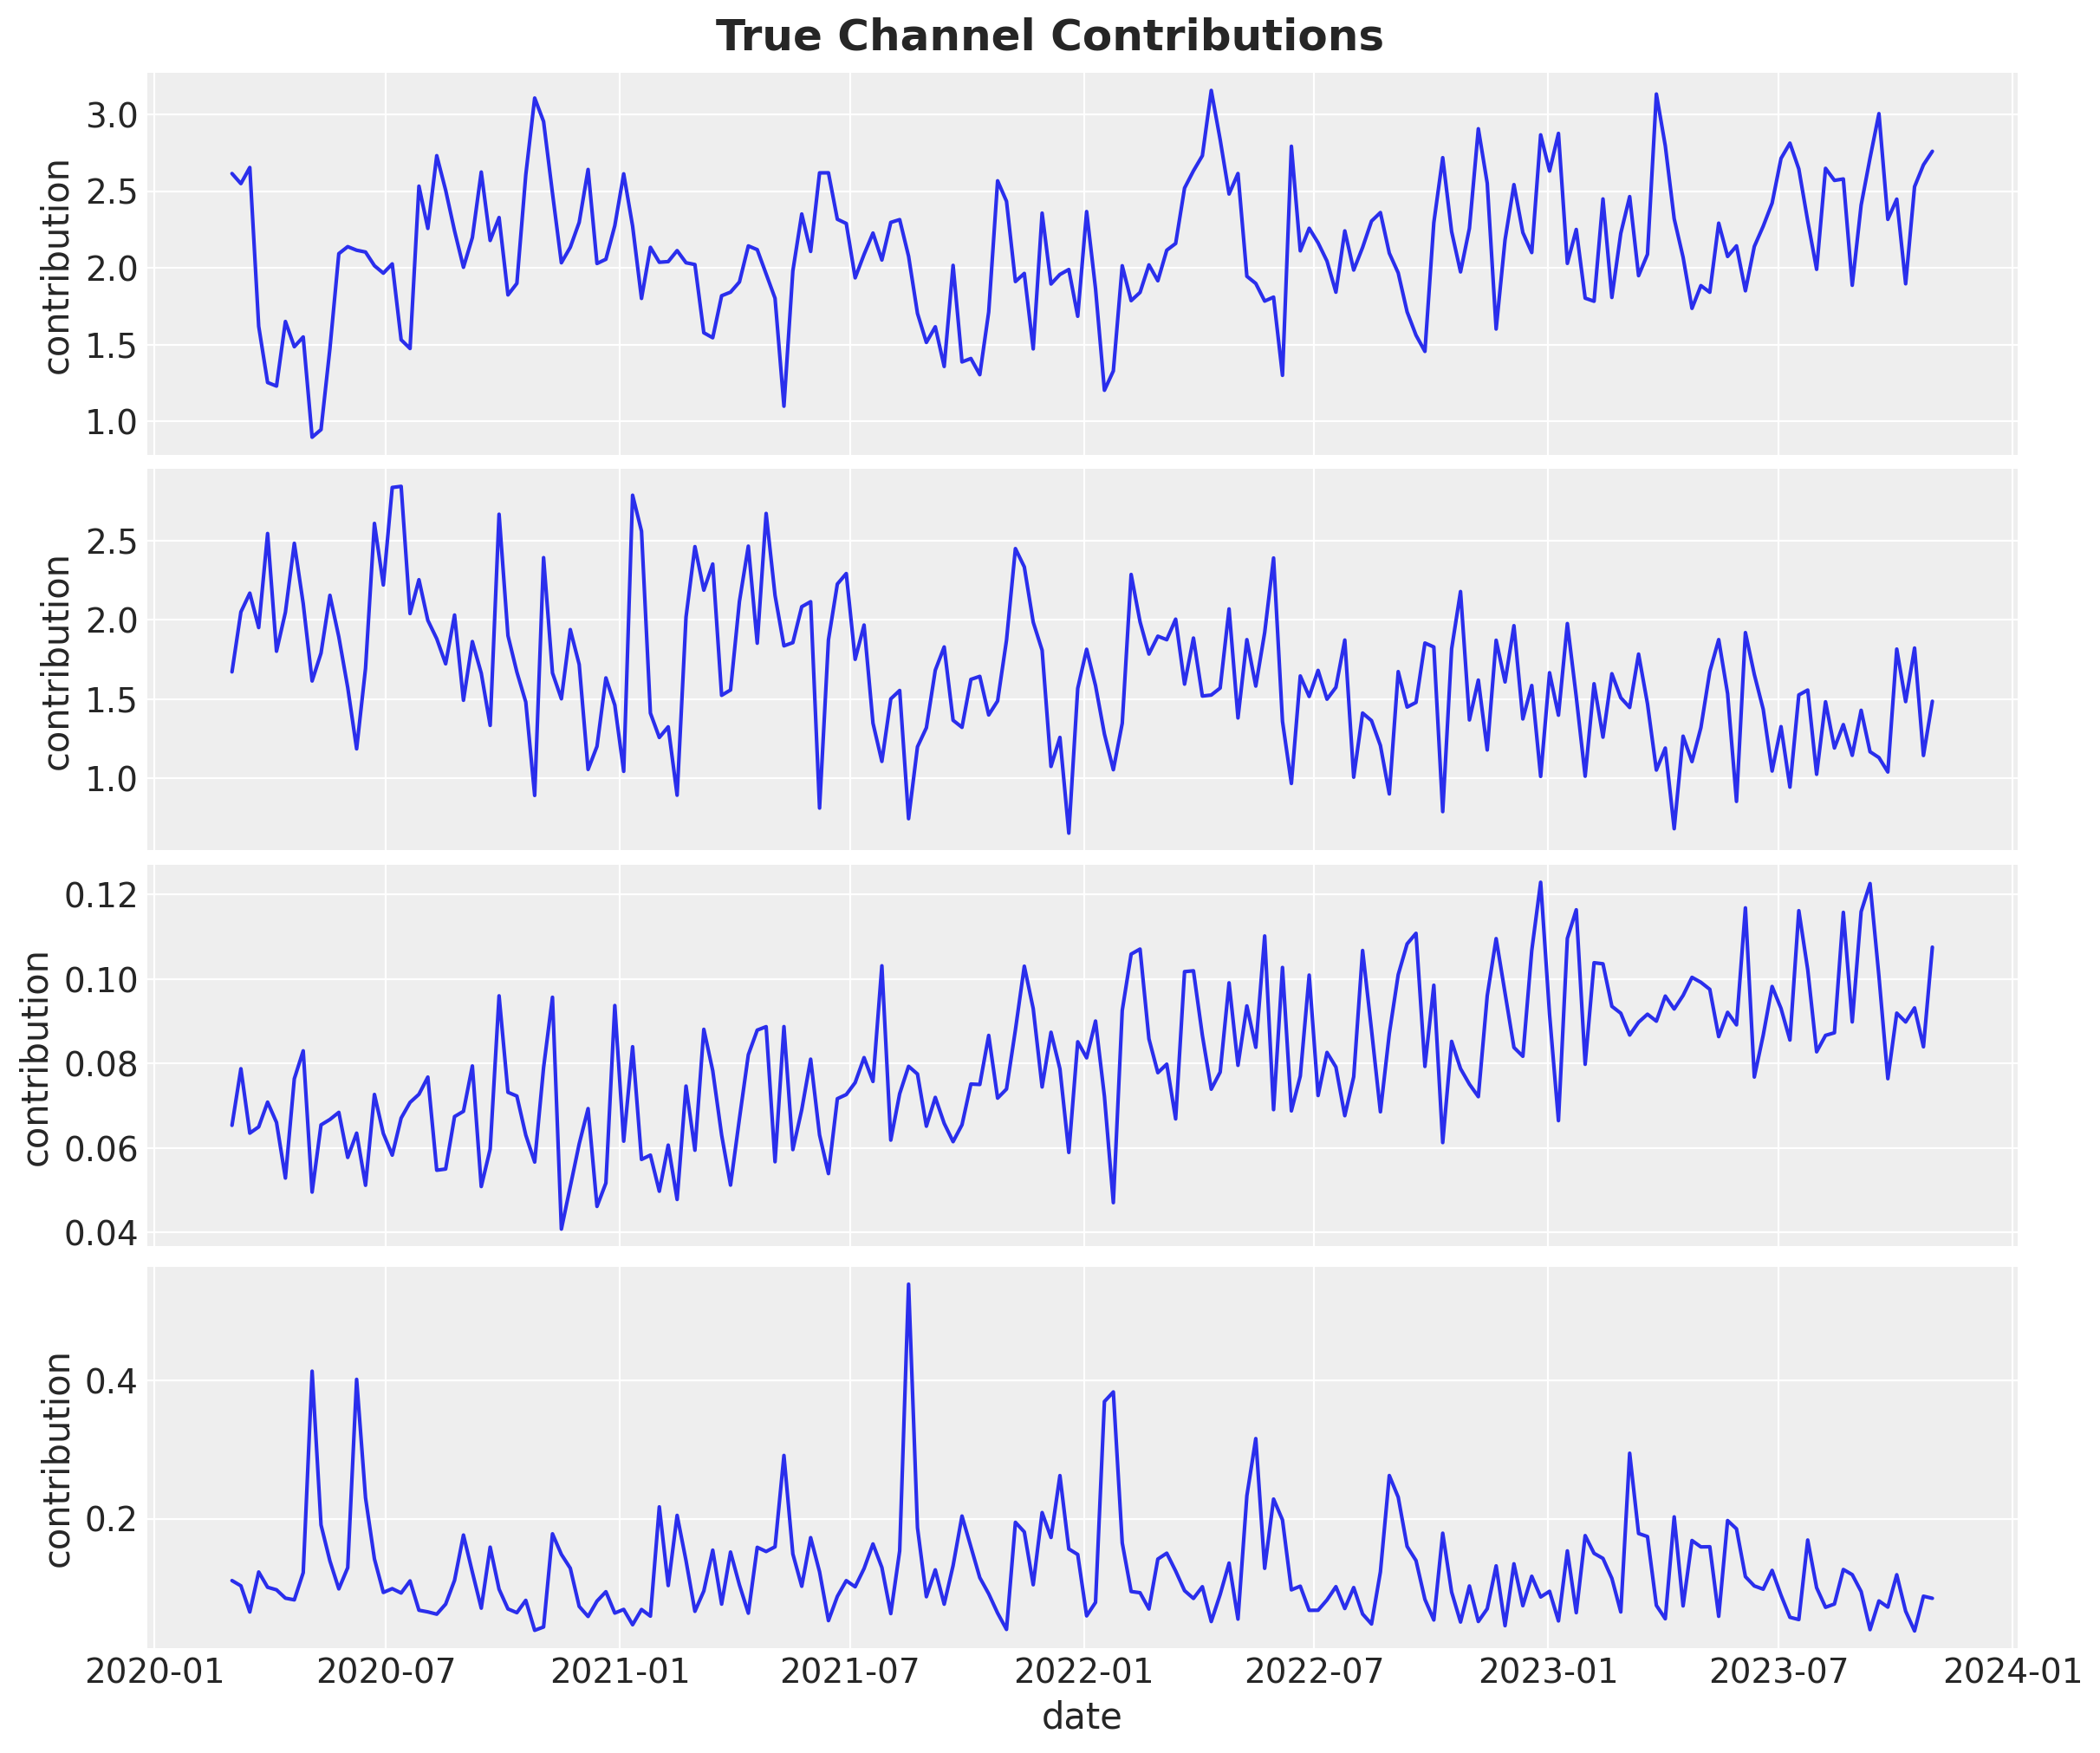

In [13]:
fig, axes = plt.subplots(
    nrows=len(coords["channel"]),
    figsize=(12, len(coords["channel"]) * 2.5),
    sharex=True,
)

for i, channel in enumerate(coords["channel"]):
    channel_contribution_observed = (
        idata_obs["prior"]["channel_contribution_original_scale"]
        .sel(chain=0, draw=0)
        .sel(channel=channel)
        .to_numpy()[l_max:]
    )

    sns.lineplot(
        data=mmm_df, x="date", y=channel_contribution_observed, color="C0", ax=axes[i]
    )

    axes[i].set(ylabel="contribution")

fig.suptitle("True Channel Contributions", fontsize=18, fontweight="bold");

## Parameter Recovery

### Fit Model

In [14]:
channel_shares = (
    mmm_df[coords["channel"]].sum(axis=0) / mmm_df[coords["channel"]].sum(axis=0).sum()
).to_numpy()

prior_sigma = len(coords["channel"]) * channel_shares

In [15]:
model_config["saturation_beta"] = Prior("HalfNormal", sigma=prior_sigma, dims="channel")

mmm = MMM(
    date_column="date",
    target_column="y_obs",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    yearly_seasonality=n_fourier_modes,
    model_config=model_config,
    sampler_config={"nuts_sampler": "nutpie"},
)

X = mmm_df[["date", *coords["channel"]]]
y = mmm_df["y_obs"]

mmm.build_model(X, y)
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)


_ = mmm.fit(
    X,
    y,
    chains=4,
    tune=1_500,
    draws=1_000,
    target_accept=0.95,
    random_seed=rng,
)

_ = mmm.sample_posterior_predictive(X=X, random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,3,0.08,255
,2500,1,0.08,63
,2500,0,0.09,63
,2500,3,0.08,63


Output()

Sampling: [y]


Output()

### Visualization

- Model Paramerters

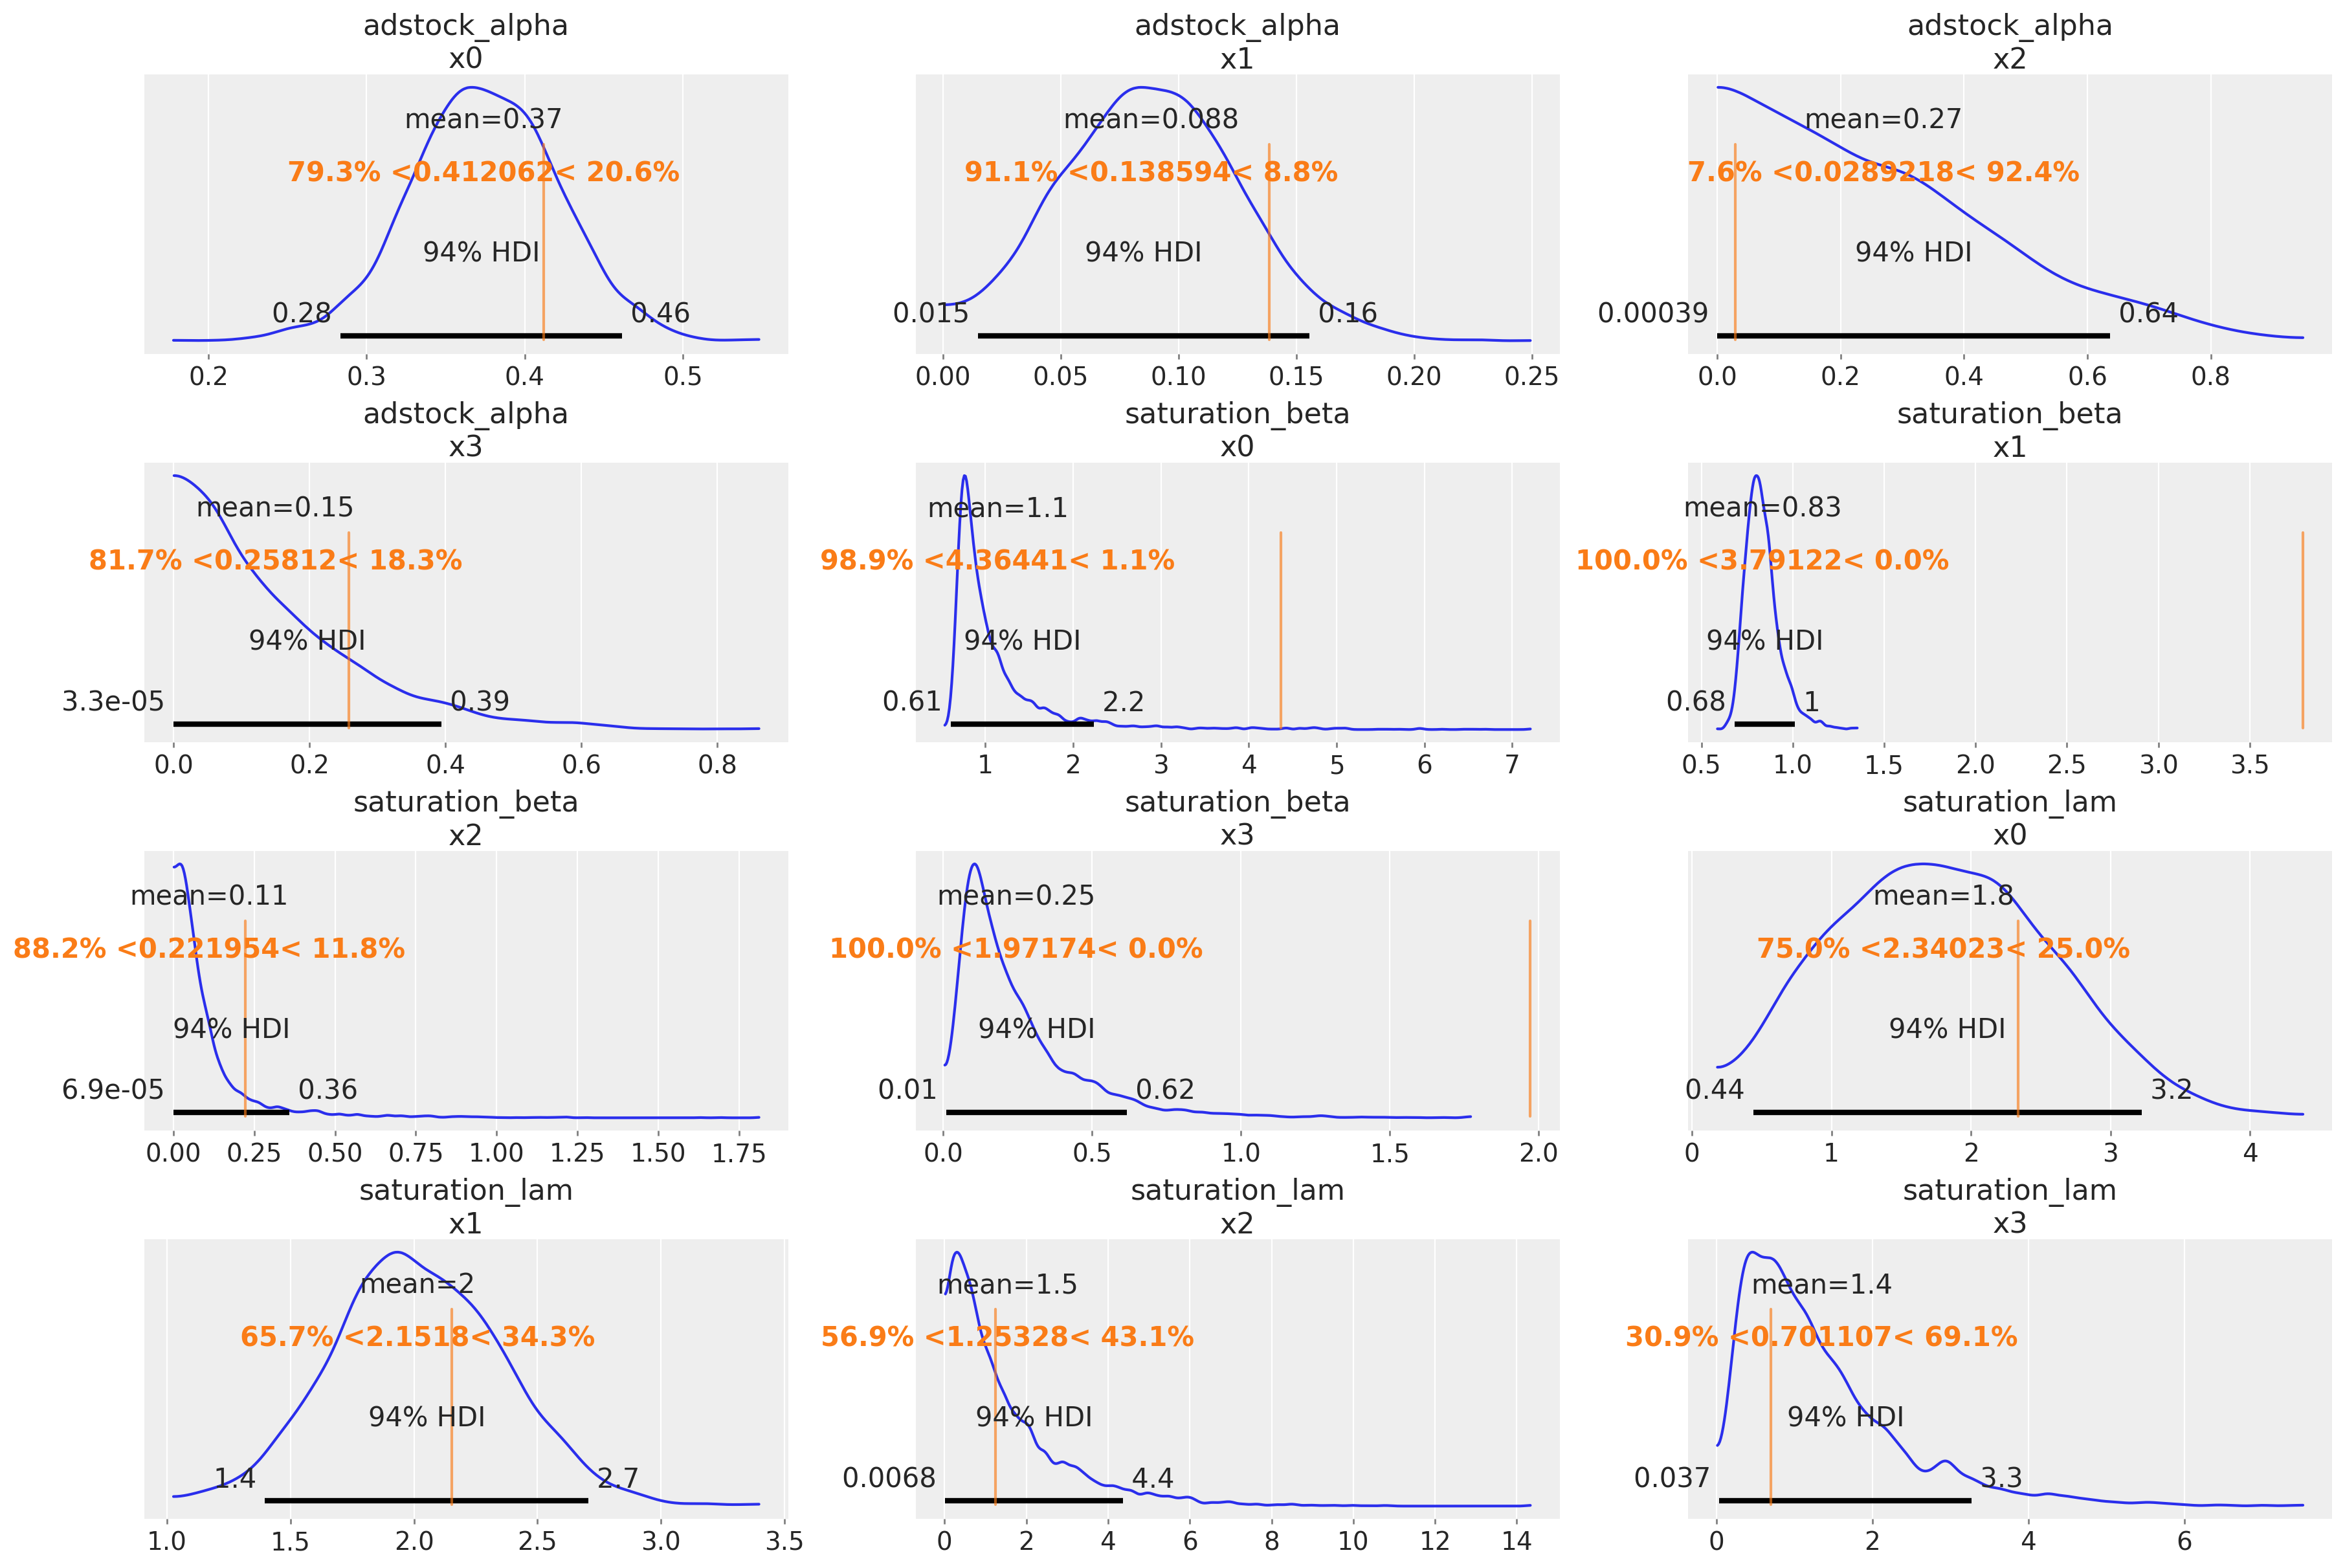

In [16]:
az.plot_posterior(
    mmm.idata,
    var_names=[
        "adstock_alpha",
        "saturation_beta",
        "saturation_lam",
    ],
    ref_val={
        "adstock_alpha": [
            {"channel": f"x{i}", "ref_val": adstock_alpha_true[i]}
            for i in range(n_channels)
        ],
        "saturation_beta": [
            {"channel": f"x{i}", "ref_val": saturation_beta_true[i]}
            for i in range(n_channels)
        ],
        "saturation_lam": [
            {"channel": f"x{i}", "ref_val": saturation_lam_true[i]}
            for i in range(n_channels)
        ],
    },
    figsize=(18, 12),
);

- Posterior Predictive

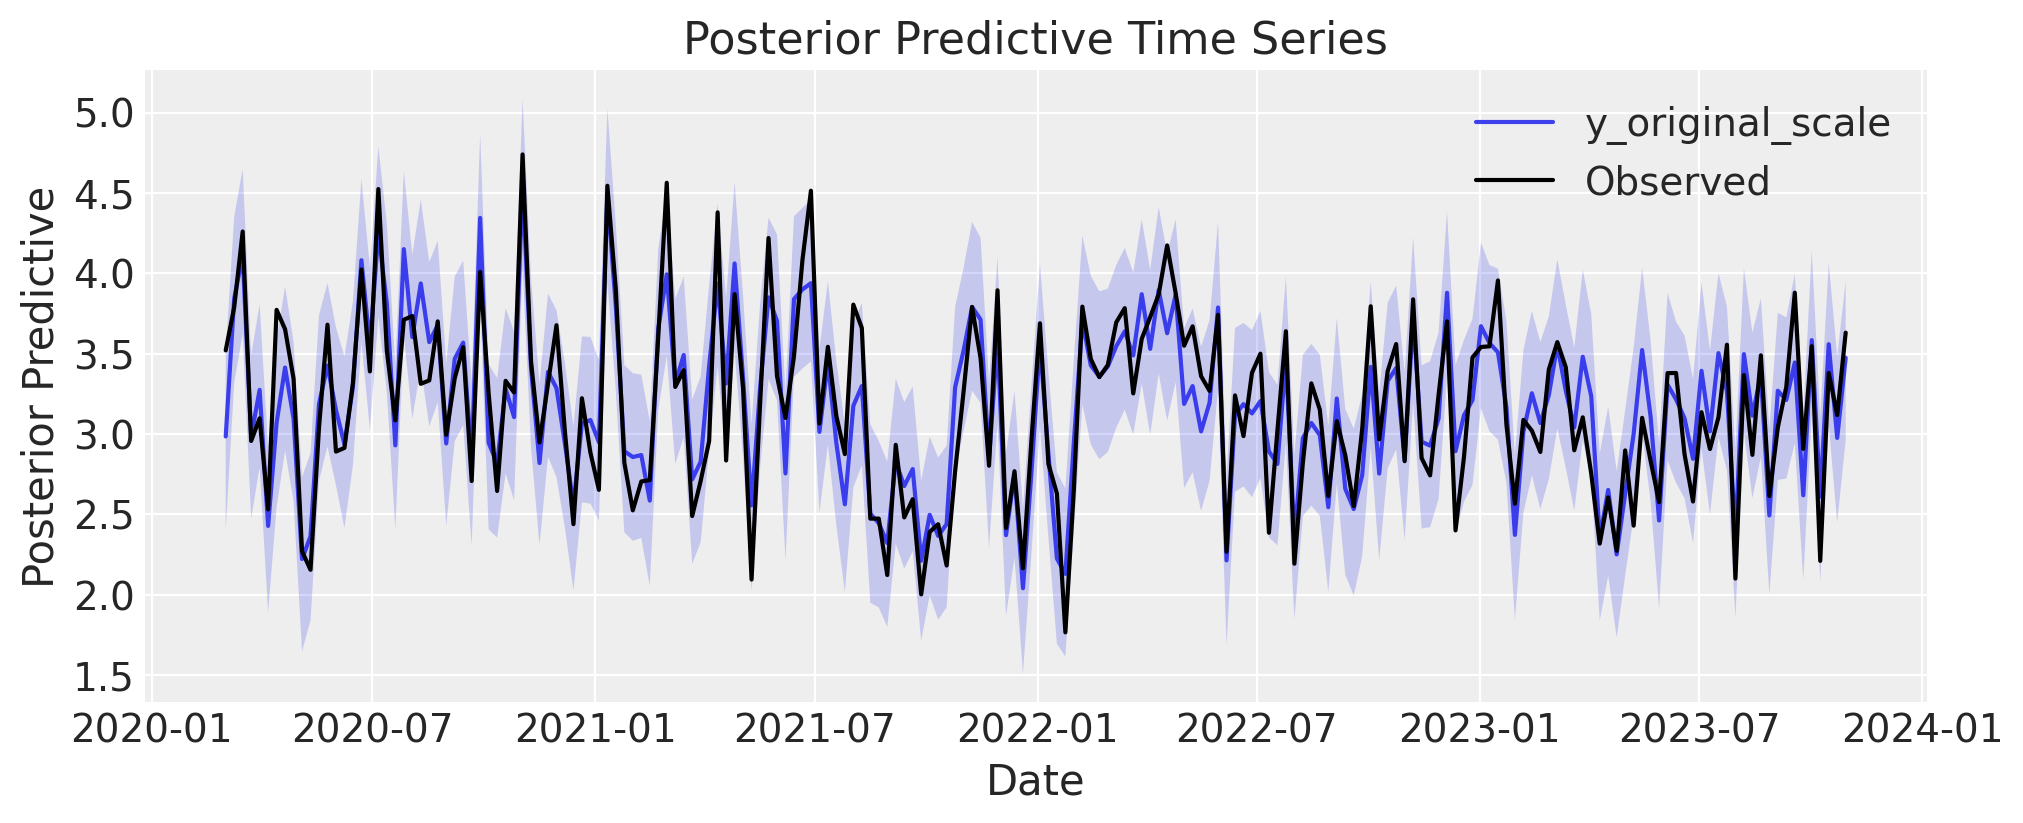

In [17]:
fig, axes = mmm.plot.posterior_predictive(var=["y_original_scale"], hdi_prob=0.94)
sns.lineplot(
    data=mmm_df, x="date", y="y_obs", color="black", label="Observed", ax=axes[0][0]
);

- Channel Contributions

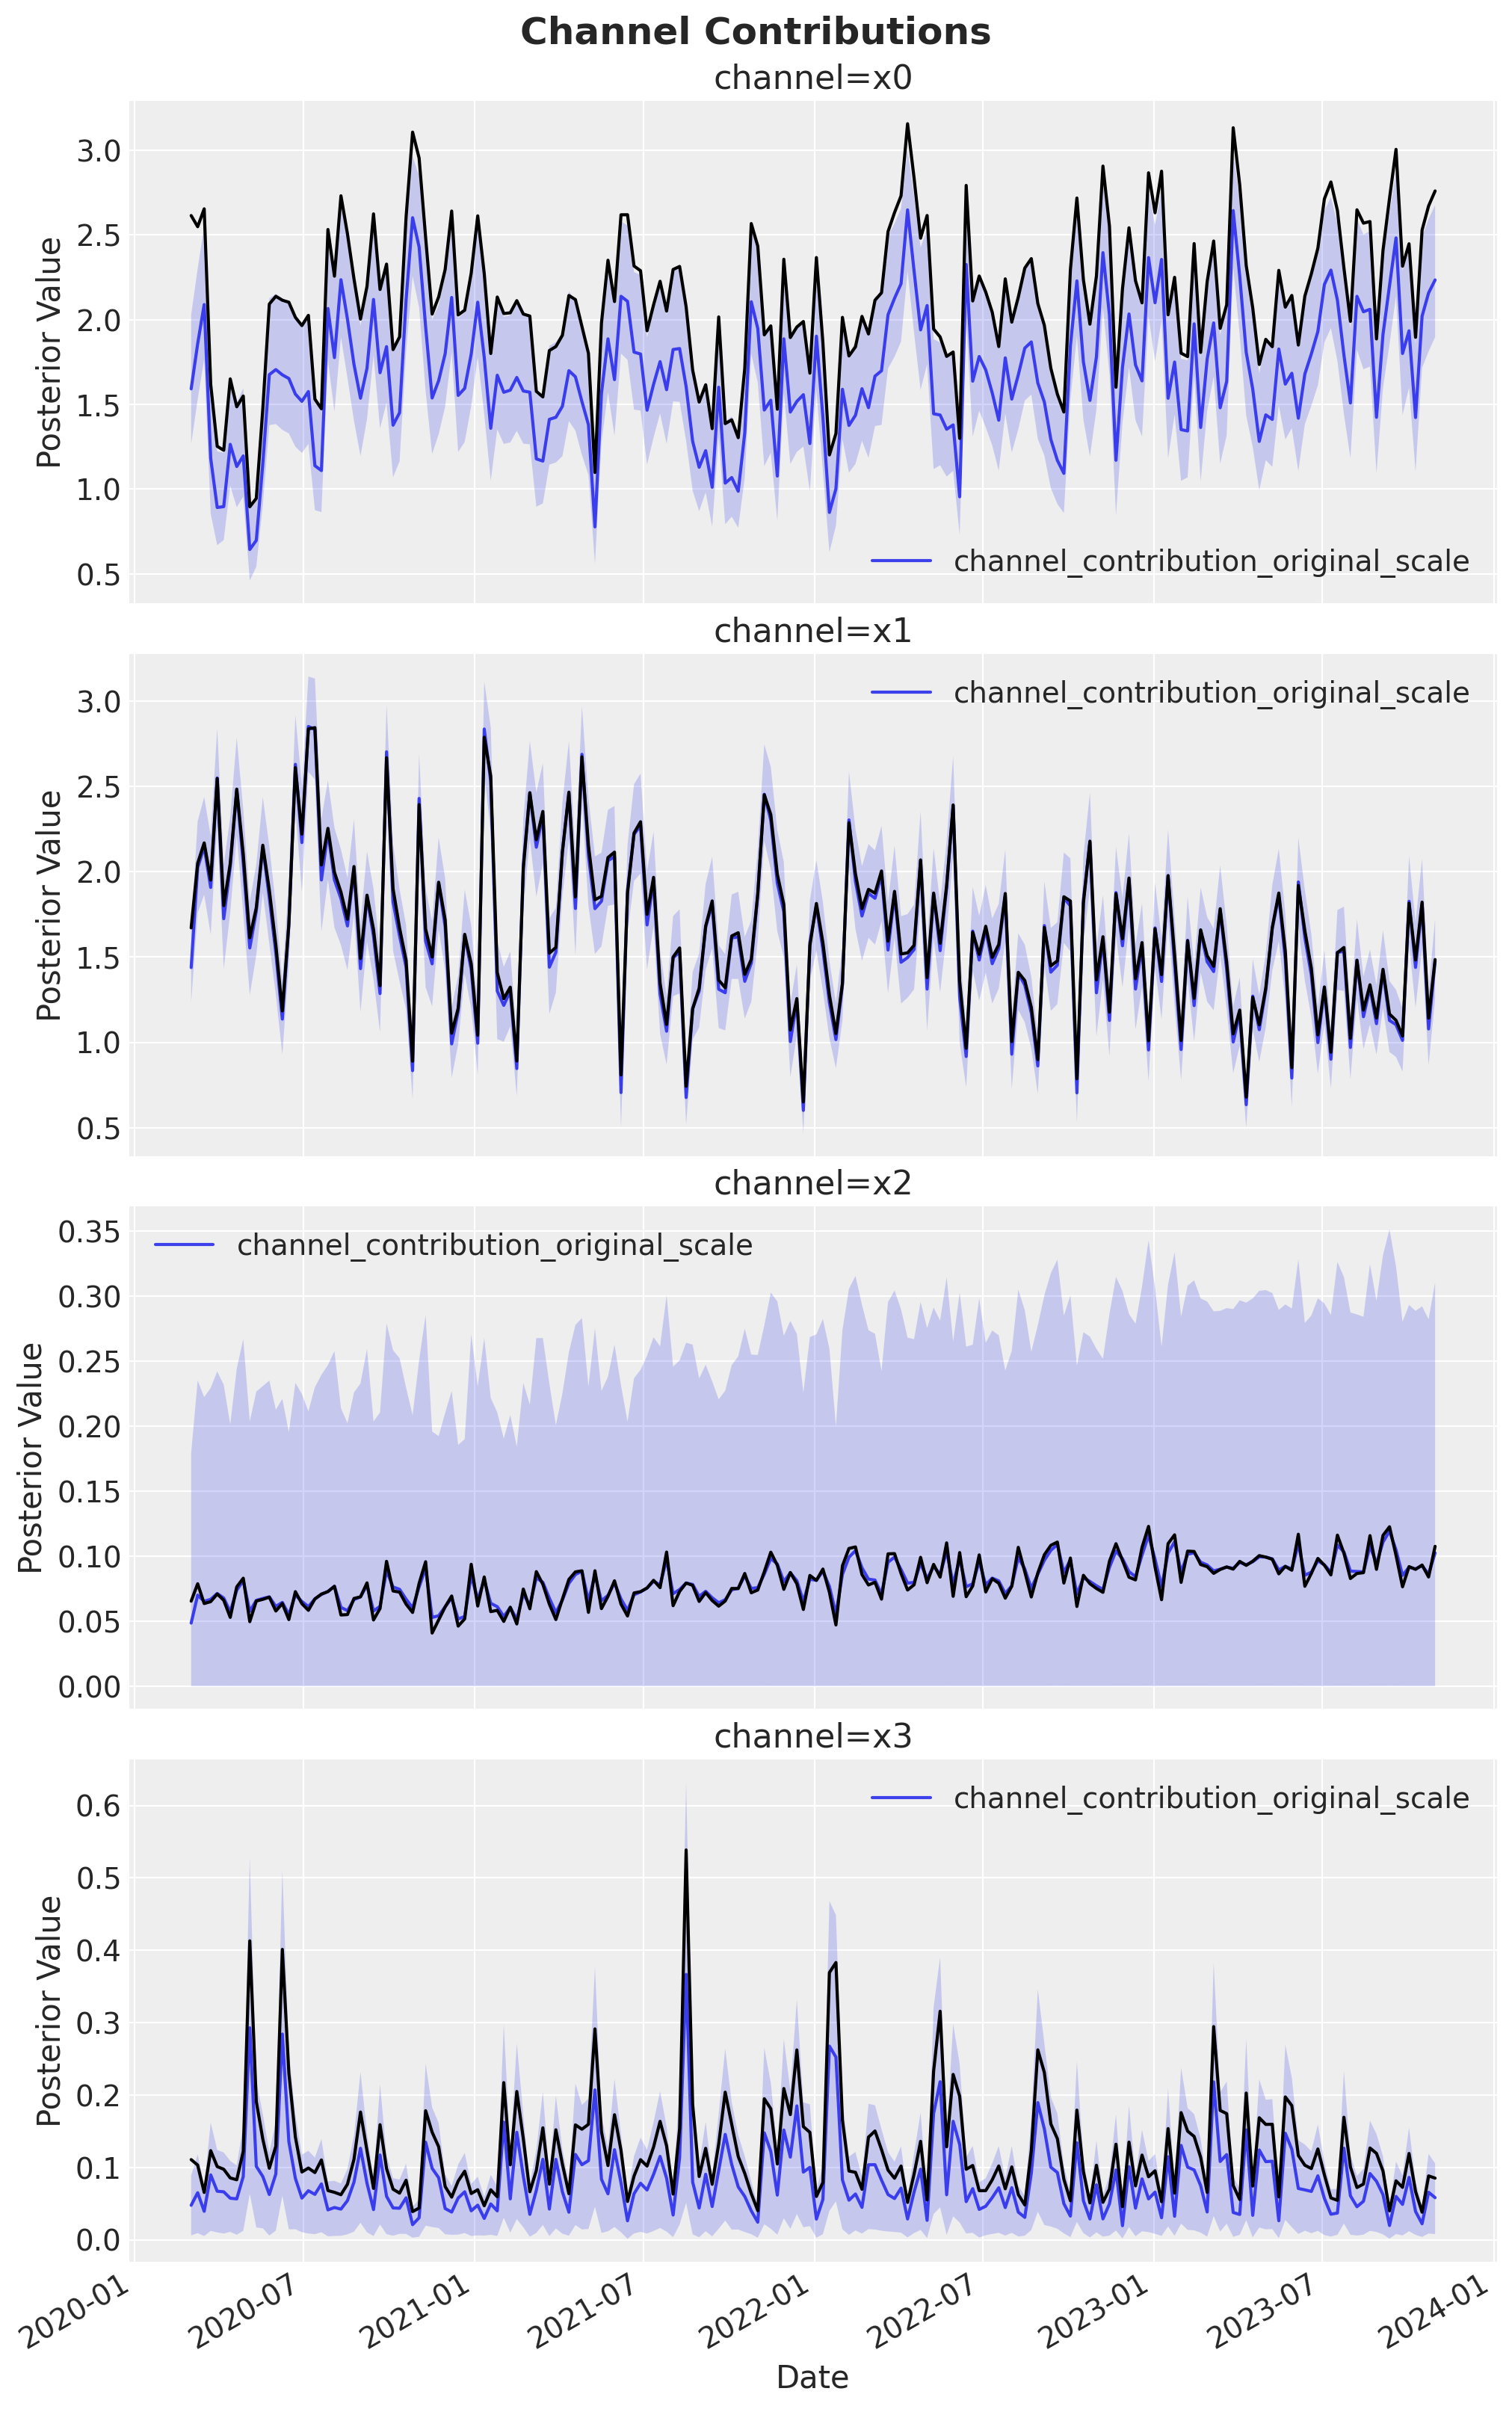

In [18]:
fig, axes = mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"], hdi_prob=0.94
)

axes = axes.flatten()

for i, channel in enumerate(coords["channel"]):
    channel_contribution_observed = (
        idata_obs["prior"]["channel_contribution_original_scale"]
        .sel(chain=0, draw=0)
        .sel(channel=channel)
        .to_numpy()[l_max:]
    )

    sns.lineplot(
        data=mmm_df,
        x="date",
        y=channel_contribution_observed,
        color="black",
        ax=axes[i],
    )

fig.autofmt_xdate()
fig.suptitle("Channel Contributions", fontsize=18, fontweight="bold");

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu, 12 Feb 2026

Python implementation: CPython
Python version       : 3.13.12
IPython version      : 9.10.0

arviz         : 0.23.4
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
pymc          : 5.27.1
pymc_extras   : 0.8.0
pymc_marketing: 0.18.0
pytensor      : 2.37.0
seaborn       : 0.13.2

Watermark: 2.6.0

